# Predicting heart failure with KNN

The objective is to predict heart failure (target) based on a number of predictors, such as anaemia, diabetes, platelets, high blood pressure, among others. The target is categorical (0: no heart failure and 1: heart failure), whereas the predictors are numeric or categorical.

In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/GWU/Data \Mining/Art of the Numerati

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/GWU/Data Mining/Art of the Numerati


## Build the model from scratch

First, let's build a classification model from scratch, with Manhattan Distance and Nearest Neighbor. Then perform 10-fold cross validation, calculate the accuracy of the model and build a confusion matrix to see the limitations of the model when it comes to claasifying the outcome. 

### _Define class classifier_

In [13]:
import copy

class Classifier:
    
    def __init__(self, filepath, testBucketNum, k):
        
        self.MedianAndDeviation = []
        self.data = []
        self.k = k

        #-----------------------------------#
        #            Read files             #
        #-----------------------------------#
        for i in range(1,11): 
            if i != testBucketNum:
                filename = "%s-%02i" % (filepath, i)
                f = open(filename)
                lines = f.readlines()
                f.close()
                # process trainfiles
                for line in lines:
                    fields = line.strip().split()
                    vector = []
                    #addInfo = []
                    for i in range(0,13): ## range of data
                        if i == 12:
                            if len(fields[i]) == 1:
                              classification = fields[i]
                        else:
                            vector.append(float(fields[i]))
                    self.data.append((classification, vector))

        # keep a copy of raw data
        self.rawData = copy.deepcopy(self.data)

        # length of vector
        self.vlen = len(self.data[0][1])

        # normalize values of each vector
        for i in range(self.vlen):
            self.normalizeColumn(i)
    #-----------------------------------#
    #           Normalization           #
    #-----------------------------------#

    # 1) Calculate median of a list of numbers
    def median(self, list_numbers):
        # sort
        sorted_list_numbers = sorted(list_numbers)

        # if odd, get middle number
        l = len(list_numbers)
        if l%2 == 1:
            return sorted_list_numbers[round(l/2)]
        # if even, calculate midpoint
        elif l%2 == 0:
            median = (sorted_list_numbers[round(l/2)] + sorted_list_numbers[round(l/2)-1]) / 2
            return median

    # 2) Calculate Abs standard deviation of a list of numbers
    def absoluteStandardDeviation(self, list_numbers, median):
        total_sum = 0
        for number in list_numbers:
            total_sum += abs(number-median)
        return total_sum / len(list_numbers)

    # 3) normalize column
    def normalizeColumn(self, columnNumber):
        # extract values for each column
        colValues = [item[1][columnNumber] for item in self.data]

        # calculate median and ASD
        median = self.median(colValues)
        asd = self.absoluteStandardDeviation(colValues, median)

        # store median and ASD values
        self.MedianAndDeviation.append((median, asd))

        # normalize data by column
        for item in self.data:
            item[1][columnNumber] = (item[1][columnNumber] - median) / asd

    # 4) normalize vector -> this will be used in classify function
    def normalizeVector(self, v):
        vector = list(v)
        for i in range(len(vector)):
            median, asd = self.MedianAndDeviation[i]
            vector[i] = (vector[i] - median) / asd
        return vector

    #-----------------------------------#
    #            Prediction             #
    #-----------------------------------#

    #1) Mahattan distance
    def ManhattanDistance(self, vector1, vector2):
        distance = 0
        for i in range(len(vector1)):
            distance += abs(vector1[i] - vector2[i])
        return distance

    # 2) KNN
    def knn(self, itemVector):   
        # a) get closest neighbors
        distances = []
        for item in self.data:
            distance = self.ManhattanDistance(itemVector, item[1])
            distances.append((distance, item))
        distances.sort()
        neighbors = distances[:self.k]

        # b) votes per neighbor
        votes = {}
        for neighbor in neighbors:
            neighborClass = neighbor[1][0]
            votes.setdefault(neighborClass, 0)
            votes[neighborClass] += 1
        
        sorted_votes = sorted(votes.items(), key= lambda x:x[1], reverse=True) 
        return sorted_votes[0][0]

    # 3) classify function
    def classify(self, itemVector):
        # a) normalizeVector
        normalVector = self.normalizeVector(itemVector)

        # b) compute nearest neighbor
        nn = self.knn(normalVector)

        # c) predict class
        return nn 

    #-----------------------------------#
    #             testData              #
    #-----------------------------------#
    
    def testData(self, filepath, testBucketNum):
        filename = "%s-%02i" % (filepath, testBucketNum)
        f = open(filename)
        lines = f.readlines()
        f.close()

        a = [] #actual
        p = [] # predicted
        corrects = 0

        for line in lines:
            fields = line.strip().split()
            vector = []
            for i in range(0,13):  ##  CHANGE THIS ACCORDING TO FORMAT OF DATA
                if i == 12:
                    if len(fields[i]) == 1:
                        realClass = fields[i]
                else:
                    vector.append(float(fields[i]))
            predictedClass = self.classify(vector)
            if realClass == predictedClass:
                corrects += 1

            a.append(realClass)
            p.append(predictedClass)

        return a, p, corrects

#-----------------------------------#
#     10-fold cross validation      #
#-----------------------------------#

def tenfold(filepath, k):
    total_a = [] #list of lists
    total_p = [] #list of lists
    total_corrects = 0

    for i in range(1,11):
        classifier = Classifier(filepath, i, k)
        a, p, corrects = classifier.testData(filepath, i)
        total_a.append(a)
        total_p.append(p)
        total_corrects += corrects

    actual = [i for l in total_a for i in l] #list reduction
    predicted = [i for l in total_p for i in l] #list reduction

    if len(actual) == len(predicted):
        accuracy = total_corrects/len(actual) *100
        return actual, predicted, accuracy
    else:
        return "error"

### _Evaluate the model_

Overall, this simple model performs well, with an accuracy of 74%. By taking a look at the correlation matrix, we can see that no heart failure (0) is better classified than heart failure (1). 

In [14]:
filepath = "./data/heart/data/dataset"
actual, predicted, accuracy = tenfold(filepath, k=3)
accuracy

74.24749163879598

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


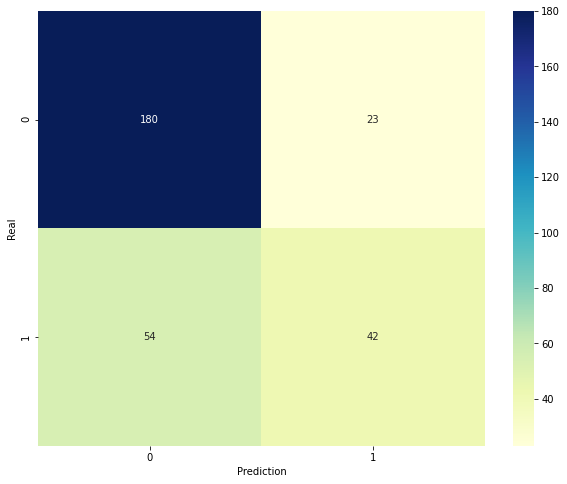

In [15]:
# create confusion matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

y_actual = pd.Series(actual, name='Real')
y_predicted = pd.Series(predicted, name='Prediction')
confusion_matrix = pd.crosstab(y_actual, y_predicted)

fig, ax = plt.subplots(figsize=(10,8))
sn.heatmap(confusion_matrix, annot=True, cmap="YlGnBu",fmt='g')
plt.show()

## Using sklearn KNeighbors Classifier

In [56]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [53]:
# read the data
df = pd.read_csv("./data/heart/data.csv")

# Check missing columns
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [51]:
#split the data into training and test set 
X = df.iloc[:, 0:12]
y = df.iloc[:, 12] #target is in position 12
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# standardize
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# define the classifier using the euclidean metric and p=2 (outcome is heart failure or not)
classifier = KNeighborsClassifier(n_neighbors=7, p=2, metric='euclidean')

# train the classifier
classifier.fit(X_train, y_train)

# predict the test set results
y_pred = classifier.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [28]:
# keep in mind that we can define a good number of neighbors with the following
import math
math.sqrt(len(y_test))

7.745966692414834

With few lines of code, we trained the KNN model. Again, the accuracy is pretty high. However, accuracy does not take into consideration class imbalance. We can take a look instead at Precision (which tells us the percentage of positive identifications that are correct), Recall (which tells us the percentage of actual positives that were identified correctly) and F1 (which is a weighted average of the precision and recall).


In [57]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))

Accuracy:  0.7166666666666667
Precision:  0.875
Recall:  0.30434782608695654
F1 score:  0.4516129032258065
